# Import Data

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# import with pandas
df = pd.read_csv('1024_samples_reconstructed_vout.csv')
df.head(5)

vout = df['VT("/out") (V)'].tolist()
time = df['time (s)'].tolist()

# remove the start of the simulation where the ADC clock isn't on yet
vout = np.array(vout[time.index(1.17e-06):])
time = np.array(time[time.index(1.17e-06):])

# Calculate FFT (V, dB, dBFS)

In [20]:
# parameters
M = 103
N = 1024
Fs = 1/2.02e-7
fstep = Fs / N
f = np.linspace(0, (N-1)*fstep, N)
Fi = (M/N) * Fs

# centering vout
vout_avg = np.average(vout)
vout = vout - vout_avg

# calculate FFT
X = np.fft.fft(vout)
X_mag = np.abs(X) / len(vout)

# normalize
f_plot = f[0:int(N/2+1)]
X_mag_plot = 2 * X_mag[0:int(N/2+1)]
X_mag_plot[0] = X_mag_plot[0] / 2

# convert to dB and dBFS
X_db = 20 * np.log10(X_mag_plot)
scale = X_mag_plot[M]
X_dbfs = 20 * np.log10(X_mag_plot / scale)


### PLOT:

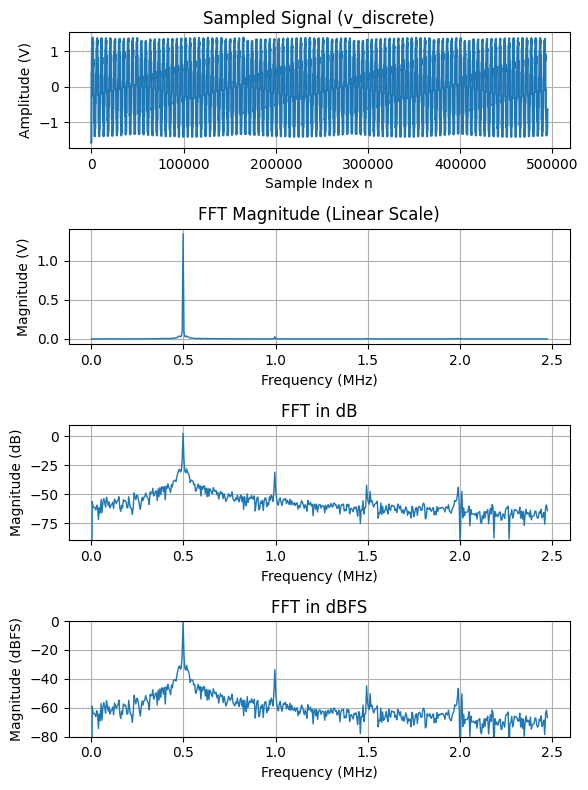

In [21]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=4, ncols=1, figsize=(6, 8))

# --- ax1: stem plot ---
ax1.plot(vout)
# plt.setp(stemlines, linewidth=0.5)
# plt.setp(markerline, markersize=3)
ax1.set_title("Sampled Signal (v_discrete)")
ax1.set_ylabel("Amplitude (V)")
ax1.set_xlabel("Sample Index n")
ax1.grid(True)


# Convert frequency to MHz
f_plot_mhz = f_plot / 1e6

# --- ax2: FFT magnitude (linear) ---
ax2.plot(f_plot_mhz, X_mag_plot, linewidth=1, markersize=2)
ax2.set_title("FFT Magnitude (Linear Scale)")
ax2.set_xlabel("Frequency (MHz)")
ax2.set_ylabel("Magnitude (V)")
ax2.grid(True)

# --- ax3: FFT in dBFS ---
# X_dbfs = 20 * np.log10(X_mag_plot / 1.65)
ax3.plot(f_plot_mhz, X_db, linewidth=1, markersize=3)
ax3.set_title("FFT in dB")
ax3.set_ylabel("Magnitude (dB)")
ax3.set_xlabel("Frequency (MHz)")
ax3.set_ylim(-90, 10)
ax3.grid(True)

# --- ax3: FFT in dBFS ---
# X_dbfs = 20 * np.log10(X_mag_plot / 1.65)
ax4.plot(f_plot_mhz, X_dbfs, linewidth=1, markersize=3)
ax4.set_title("FFT in dBFS")
ax4.set_ylabel("Magnitude (dBFS)")
ax4.set_xlabel("Frequency (MHz)")
ax4.set_ylim(-80, 0)
ax4.grid(True)



plt.tight_layout()
plt.show()


# Calculate Dynamic Characteristics:

Signal to Noise Ratio (SNR) = RMS(SIGNAL) / RMS(NOISE)\
Signal to Noise & Distortion Ratio (SINAD) = RMS(SIGNAL) / RMS(Noise and distortion)\
Effective Number of Bits (ENOB) = The actual resolution of the ADC in bits due to SINAD\
Total Harmonic Distortion (THD) = THD is estimated by the rss of the second through the tenth harmonics (including alias's), inclusive. (IEEE 1241)\
Spurious Free Dynamic Range (SFDR) = The magnitude of the first harmonic in dBFS\
Dynamic Range (DR) = The magnitude of the last harmonic in dBFS


## SNR

In [22]:
# index of DC, fundamental frequency, and first 3 harmonics (not harmonic alias's)
dc_idx = 0
fundamental_freq_idx = M
harmonics_idx = [2*M, 3*M, 4*M]

# remove those indexes from the magnitude data
noise = np.delete(X_mag_plot, [dc_idx, fundamental_freq_idx, harmonics_idx[0], harmonics_idx[1], harmonics_idx[2]])

# calculate noise rms
noise_rms = np.sqrt(np.mean(noise**2))
print(f"NOISE RMS: {noise_rms}")

# signal rms will just be equal to the magnitude at the fundamental frequency because the data is coherently sampled and there is negligible spectral leakage
signal_mag = X_mag_plot[M]
signal_rms = np.sqrt(np.mean(signal_mag**2))
print(f"SIGNAL MAGNITUDE: {signal_rms}")

# calculate SNR
snr = 20 * np.log10(signal_rms / noise_rms)
print(f"SNR (dB): {snr}")

NOISE RMS: 0.00795435625988913
SIGNAL MAGNITUDE: 1.342459605938765
SNR (dB): 44.54592377095822


## SINAD

In [23]:
# remove just the DC and fundamental frequencies
noise_and_distortion = np.delete(X_mag_plot, [dc_idx, fundamental_freq_idx])

# calcualte NAD RMS
noise_and_distortion_rms = np.sqrt(np.mean(noise_and_distortion**2))
print(f"NOISE AND DISTORTION RMS: {noise_and_distortion_rms}")

# use signal rms from SNR calculation
print(f"SIGNAL MAGNITUDE: {signal_rms}")

# calculate SINAD
sinad = 20 * np.log10(signal_rms / noise_and_distortion_rms)
print(f"SINAD (dB): {sinad}")

NOISE AND DISTORTION RMS: 0.008041400685826866
SIGNAL MAGNITUDE: 1.342459605938765
SINAD (dB): 44.45139048405213


## ENOB

In [24]:
# calculate ENOB
# enob = (snr - 1.76) / 6.02 # use this equation if signal ranged the full scale of the ADC, in my case I narrowed the amlpitude by 5mV of the full scale

actual_scale = X_mag_plot[M]
enob = (sinad - 1.76 + 20 * np.log10(1.65/actual_scale))/6.02
print(f"ENOB: {enob}")

ENOB: 7.389210104956484


## THD

In [25]:
THD_list = []
indexes = []

# IEEE standard says we need the first 10 harmonics including alias's
# we loop through 12 because it includes the fundamental frequency, then remove it later
for k in range(0, 11):
    harmonic_freq = k * Fi
    # Alias computation
    alias = harmonic_freq % Fs
    if alias > Fs / 2:
        alias = Fs - alias

    # Find closest index in frequency array
    idx = int(round(alias / Fs * N))
    if idx < len(X_mag):
        THD_list.append(X_dbfs[idx])
        indexes.append(idx)

# remove the fundamental frequency
THD_list = np.array(THD_list[1:])
indexes = np.array(indexes[1:])

# calculate THD (RSS)
THD = 20*np.log10(np.sqrt(np.sum((10**(THD_list / 20))**2)))
print(f"THD (dbFS): {THD}")

THD (dbFS): 0.003721237112897732


## Results

In [26]:
print(f"SNR (dB): {snr}")
print(f"SINAD (dB): {sinad}")
print(f"ENOB: {enob}")
print(f"THD (dbFS): {THD}")

SNR (dB): 44.54592377095822
SINAD (dB): 44.45139048405213
ENOB: 7.389210104956484
THD (dbFS): 0.003721237112897732


## Plot

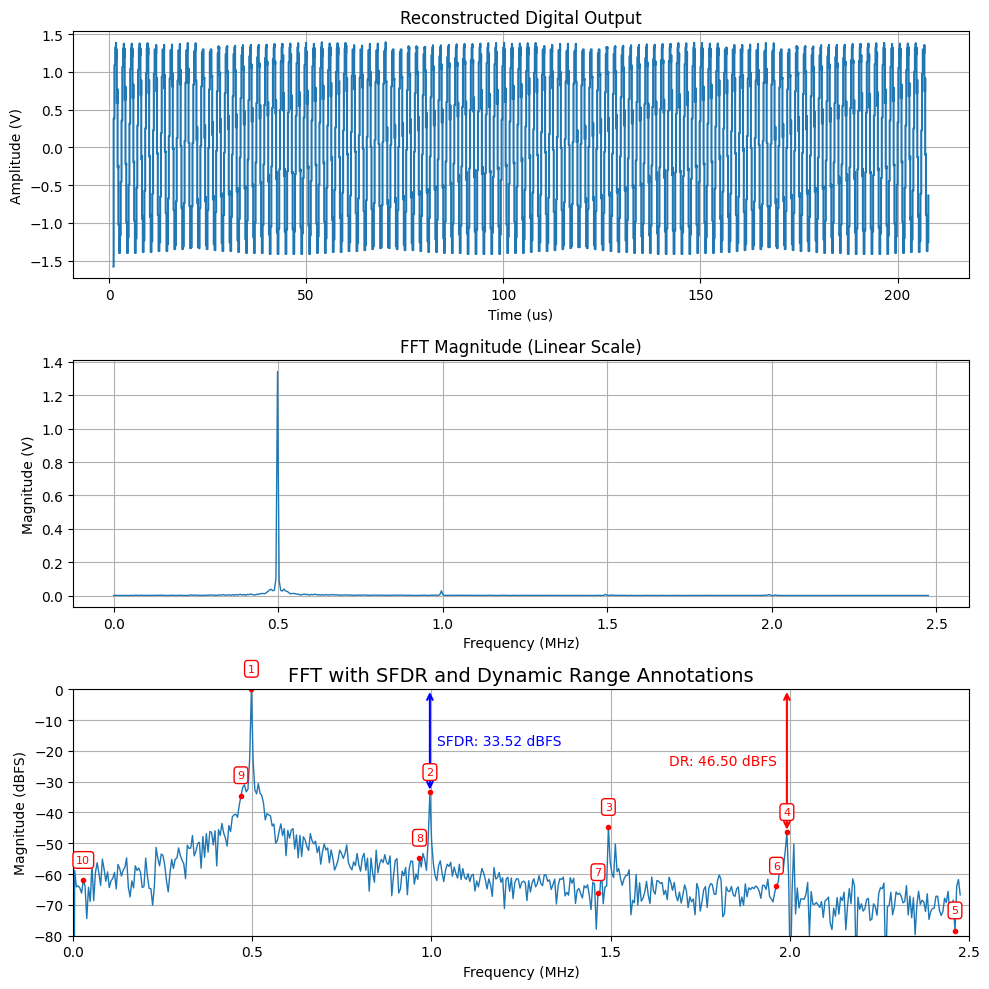

In [27]:
# --- Plots ---
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
f_plot_mhz = f_plot / 1e6

# --- ax1: stem plot ---
ax1.plot(time*1e6, vout)
ax1.set_title("Reconstructed Digital Output")
ax1.set_ylabel("Amplitude (V)")
ax1.set_xlabel("Time (us)")
ax1.grid(True)


# --- FFT Magnitude (linear scale) ---
ax2.plot(f_plot_mhz, X_mag_plot, linewidth=1)
ax2.set_title("FFT Magnitude (Linear Scale)")
ax2.set_xlabel("Frequency (MHz)")
ax2.set_ylabel("Magnitude (V)")
ax2.grid(True)

# --- FFT dBFS ---
ax3.plot(f_plot_mhz, X_dbfs, '-', linewidth=1, markersize=3)
ax3.set_ylim(-80, 0)
ax3.set_xlim(0, 2.5)
ax3.set_title("FFT with SFDR and Dynamic Range Annotations", fontsize=14)
ax3.set_xlabel("Frequency (MHz)")
ax3.set_ylabel("Magnitude (dBFS)")
ax3.grid(True)


# --- DR Arrow (4th harmonic) ---
harmonic_idx = 4 * M
harmonic_dbfs = X_dbfs[harmonic_idx]
ax3.annotate('', xy=(f_plot_mhz[harmonic_idx], harmonic_dbfs), xytext=(f_plot_mhz[harmonic_idx], 0),
             arrowprops=dict(arrowstyle='<->', color='red', linewidth=1.5))
ax3.text(f_plot_mhz[harmonic_idx] - 0.33, harmonic_dbfs / 2,
         f"DR: {abs(harmonic_dbfs):.2f} dBFS", color='red', va='center', fontsize=10)

# --- SFDR Arrow (2nd harmonic) ---
harmonic_idx = 2 * M
harmonic_dbfs = X_dbfs[harmonic_idx]
ax3.annotate('', xy=(f_plot_mhz[harmonic_idx], harmonic_dbfs), xytext=(f_plot_mhz[harmonic_idx], 0),
             arrowprops=dict(arrowstyle='<->', color='blue', linewidth=1.5))
ax3.text(f_plot_mhz[harmonic_idx] + 0.02, harmonic_dbfs / 2,
         f"SFDR: {abs(harmonic_dbfs):.2f} dBFS", color='blue', va='center', fontsize=10)


for j, idx in enumerate(indexes):
    x = f[idx] / 1e6
    y = X_dbfs[idx]
    ax3.plot(x, y, 'ro', markersize=3)
    ax3.text(
        x, y + 5, f"{j+1}",
        ha='center', va='bottom',
        fontsize=8, color='red',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', linewidth=1)
    )

plt.tight_layout()
plt.show()
